# Loading File Data

In [5]:
import pickle
import numpy as np

def load_batch(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        X = data[b'data']
        y = data[b'labels']
        X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to (N, 32, 32, 3)
        return X, np.array(y)

# Loading Data

In [8]:
X_train, y_train = [], []

for i in range(1, 6):
    X, y = load_batch(f'cifar-10-batches-py/data_batch_{i}')
    X_train.append(X)
    y_train.append(y)

X_train = np.concatenate(X_train)
Y_train = np.concatenate(y_train)

# shuffle data
shuffle_idx = np.random.permutation(len(X_train))
X_train = X_train[shuffle_idx]
Y_train = Y_train[shuffle_idx]

X_test, Y_test = load_batch('cifar-10-batches-py/test_batch')

# shuffle data
shuffle_idx = np.random.permutation(len(X_test))
X_test = X_test[shuffle_idx]
Y_test = Y_test[shuffle_idx]

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalize
X_train /= 255.0
X_test /= 255.0

# Shape of Data

In [10]:
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (50000, 32, 32, 3)
Shape of Y_train:  (50000,)
Shape of X_test:  (10000, 32, 32, 3)
Shape of Y_test:  (10000,)


# Label Dictionary

In [12]:
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

# Pick a random image

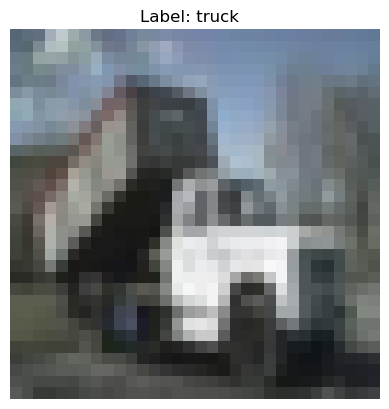

In [14]:
import matplotlib.pyplot as plt

idx = np.random.randint(len(X_train))

img = (X_train[idx]*255).astype(np.uint8)
plt.imshow(img)
plt.title(f"Label: {cifar10_labels[Y_train[idx]]}  ")
plt.axis('off')
plt.show()

# Padding

In [16]:
def add_padding(image, pad):
    # image shape: (H, W, C)
    return np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='constant')


# padding first data
X_train_padded = add_padding(X_train[0], pad=1)
print("Padded shape:", X_train_padded.shape)

Padded shape: (34, 34, 3)


# Convolution function

In [19]:
def conv2d(image, filters, stride=1):
    """
    Parameters:
        input   : np.ndarray of shape (H, W, C) - input image
        filters : np.ndarray of shape (num_filters, fH, fW, C)
        stride  : int - stride value

    Returns:
        output  : np.ndarray of shape (out_H, out_W, num_filters)
    """
    
    H, W, C = image.shape
    num_filters, fH, fW, _ = filters.shape

    out_H = (H - fH) // stride + 1
    out_W = (W - fW) // stride + 1

    output = np.zeros((out_H, out_W, num_filters))

    for k in range(num_filters):
        f = filters[k]
        for i in range(out_H):
            for j in range(out_W):
                h_start = i * stride
                h_end = h_start + fH
                w_start = j * stride
                w_end = w_start + fW

                region = image[h_start:h_end, w_start:w_end, :]
                if region.shape == f.shape:
                    output[i, j, k] = np.sum(region * f)

    return output

## Example how convolution work

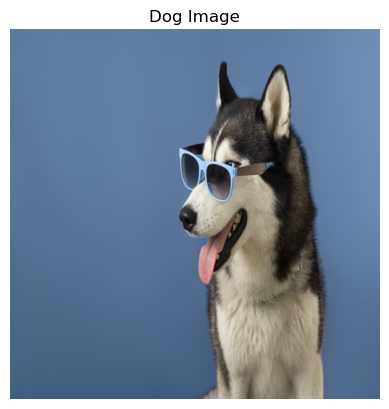

In [23]:
from PIL import Image

img = Image.open("dog.jpg").resize((512, 512))
image_np = np.array(img)

plt.imshow(image_np)
plt.axis('off')
plt.title("Dog Image")
plt.show()

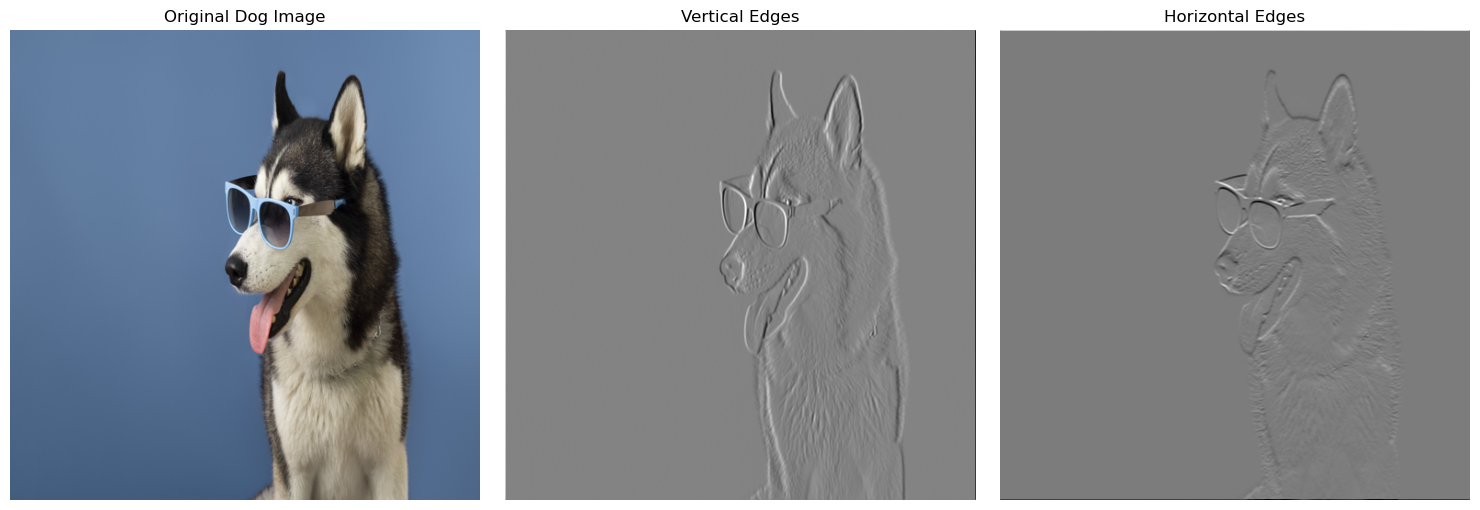

In [27]:
# Vertical Sobel Filter
sobel_vertical = np.array([
    [-2, 0, 2],
    [-2, 0, 2],
    [-2, 0, 2]
])

# Horizontal Sobel Filter
sobel_horizontal = np.array([
    [-2, -2, -2],
    [ 0,  0,  0],
    [ 2,  2,  2]
])

# Expand both filters for 3 channels (RGB)
filter_v = np.stack([sobel_vertical]*3, axis=-1)  # (3, 3, 3)
filter_h = np.stack([sobel_horizontal]*3, axis=-1)

# Combine into a filter bank: (2, 3, 3, 3)
filters = np.stack([filter_v, filter_h], axis=0)

# Apply convolution
padded_image = add_padding(image_np,pad=1)
feature_map = conv2d(padded_image, filters, stride=1)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Original Dog Image")
axs[0].axis('off')

axs[1].imshow(feature_map[:, :, 0], cmap='gray')
axs[1].set_title("Vertical Edges")
axs[1].axis('off')

axs[2].imshow(feature_map[:, :, 1], cmap='gray')
axs[2].set_title("Horizontal Edges")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Max Pooling

In [30]:
def max_pooling(feature_map, size=2, stride=2):
    H, W, D = feature_map.shape
    out_H = (H - size) // stride + 1
    out_W = (W - size) // stride + 1
    output = np.zeros((out_H, out_W, D))
    
    for d in range(D):
        for i in range(out_H):
            for j in range(out_W):
                h_start = i * stride
                h_end = h_start + size
                w_start = j * stride
                w_end = w_start + size
                output[i, j, d] = np.max(feature_map[h_start:h_end, w_start:w_end, d])
    
    return output

## Apply max pool on edges of above image

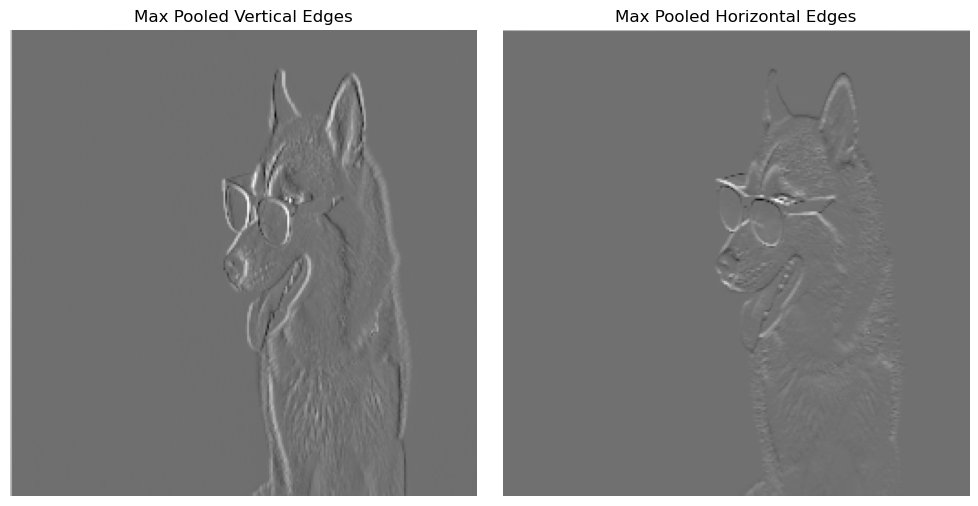

In [32]:
# Extract both vertical and horizontal edge maps
vertical_map = feature_map[:, :, 0][:, :, np.newaxis]    # shape: (H, W, 1)
horizontal_map = feature_map[:, :, 1][:, :, np.newaxis]  # shape: (H, W, 1)

# Apply max pooling to both
pooled_vertical = max_pooling(vertical_map, size=2, stride=2)
pooled_horizontal = max_pooling(horizontal_map, size=2, stride=2)

# Plot both pooled results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(pooled_vertical[:, :, 0], cmap='gray')
axs[0].set_title("Max Pooled Vertical Edges")
axs[0].axis('off')

axs[1].imshow(pooled_horizontal[:, :, 0], cmap='gray')
axs[1].set_title("Max Pooled Horizontal Edges")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Why we use Padding, Convolution and Max Pooling

### 1. Padding:
 Padding adds extra pixels (usually zeros) around the image.
 It helps keep the size of the output same as the input and allows edge features to be learned.

### 2. Convolution:
 Convolution applies filters to the image to detect important patterns like edges, corners, or textures.
 It helps in extracting features from the image using fewer parameters.


### 3. Max Pooling:
 Max pooling reduces the size of the feature maps by taking the largest value in each region.
 It makes the model faster, reduces overfitting, and helps it focus on the most important features.

In [35]:
# Step 1: Original image shape
print("Original Image Shape:", image_np.shape)

# Step 2: Padding
padded_image = add_padding(image_np, pad=1)
print("After Padding:", padded_image.shape)

# Step 3: Convolution
# We'll use 8 filters of shape (3, 3, 3)
filters = np.random.randn(8, 3, 3, 3)
feature_map = conv2d(padded_image, filters, stride=2)
print("After Convolution:", feature_map.shape)

# Step 4: Max Pooling
pooled_output = max_pooling(feature_map, size=2, stride=2)
print("After Max Pooling:", pooled_output.shape)

Original Image Shape: (512, 512, 3)
After Padding: (514, 514, 3)
After Convolution: (256, 256, 8)
After Max Pooling: (128, 128, 8)


# Defining neural network functions

### Forward Propagation

<div align="center"><b>Z[1] = W[1] × X + b[1]</b></div>
<div align="center"><b>A[1] = ReLU(Z[1])</b></div>
<div align="center"><b>Z[2] = W[2] × A[1] + b[2]</b></div>
<div align="center"><b>A[2] = softmax(Z[2])</b></div>

### Backward Propagation

<div align="center"><b>dZ[2] = A[2] - Y</b></div>
<div align="center"><b>dW[2] = (1/m) × dZ[2] × A[1]<sup>T</sup></b></div>
<div align="center"><b>db[2] = (1/m) × sum(dZ[2])</b></div>

<div align="center"><b>dZ[1] = (W[2]<sup>T</sup> × dZ[2]) ⊙ ReLU'(Z[1])</b></div>
<div align="center"><b>dW[1] = (1/m) × dZ[1] × X<sup>T</sup></b></div>
<div align="center"><b>db[1] = (1/m) × sum(dZ[1])</b></div>


### Parameter Updates

<div align="center"><b>W[2] = W[2] - α × dW[2]</b></div>
<div align="center"><b>b[2] = b[2] - α × db[2]</b></div>
<div align="center"><b>W[1] = W[1] - α × dW[1]</b></div>
<div align="center"><b>b[1] = b[1] - α × db[1]</b></div>

### Variable Shapes

<div align="center"><b>X: 2048 × m</b></div>
<div align="center"><b>W[1]: 1024 × 2048</b></div>
<div align="center"><b>b[1]: 1024 × 1</b></div>
<div align="center"><b>Z[1], A[1]: 1024 × m</b></div>
<div align="center"><b>W[2]: 10 × 1024</b></div>
<div align="center"><b>b[2]: 10 × 1</b></div>
<div align="center"><b>Z[2], A[2]: 10 × m</b></div>



In [38]:
def init_params(input_size, hidden_size, output_size):
    W1 = np.random.randn(hidden_size, input_size).astype(np.float32) * np.sqrt(2. / input_size)
    b1 = np.zeros((hidden_size, 1), dtype=np.float32)
    W2 = np.random.randn(output_size, hidden_size).astype(np.float32) * np.sqrt(2. / hidden_size)
    b2 = np.zeros((output_size, 1), dtype=np.float32)
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)
    
def ReLU_deriv(Z):
    return (Z > 0).astype(np.float32)

def softmax(Z):
    Z = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def one_hot(Y, num_classes=None):
    if num_classes is None: num_classes = np.max(Y) + 1
    one_hot_Y = np.zeros((num_classes, Y.size), dtype=np.float32)
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1 @ X + b1
    A1 = ReLU(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y, A2.shape[0])
    m = X.shape[1]
    dZ2 = A2 - one_hot_Y
    dW2 = dZ2 @ A1.T / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = W2.T @ dZ2 * ReLU_deriv(Z1)
    dW1 = dZ1 @ X.T / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2


In [42]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, W1, b1, W2, b2, alpha, iterations):
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

def gradient_descent_batchwise(X, Y, W1, b1, W2, b2, alpha, iterations, batch_size=64):
    m = X.shape[1]
    for i in range(iterations):
        print(f"Starting iteration: {i+1}")
    
        permutation = np.random.permutation(m)
        X = X[:, permutation]
        Y = Y[permutation]

        for k in range(0, m, batch_size):
            X_batch = X[:, k:k+batch_size]
            Y_batch = Y[k:k+batch_size]

            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 10 == 0:
            _, _, _, A2_full = forward_prop(W1, b1, W2, b2, X)
            predictions = get_predictions(A2_full)
            acc = get_accuracy(predictions, Y)
            print(f"Iteration {i+1}, Accuracy: {acc:.4f}")

            # Compute loss
            logits = np.clip(A2_full, 1e-8, 1)
            one_hot_Y = one_hot(Y, A2_full.shape[0])
            loss = -np.mean(np.sum(one_hot_Y * np.log(logits), axis=0))

            print(f"Iteration {i+1}, loss: {loss:.4f}")
            
            # Save weights
            np.savez("weights_biases.npz", W1=W1, b1=b1, W2=W2, b2=b2)
            print(f"Saved weights at iteration {i+1}")

    return W1, b1, W2, b2

In [43]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index].reshape(3, 32, 32).transpose(1, 2, 0)  # shape: (32, 32, 3)
    
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    
    print("Prediction:", prediction[0])
    print("Label:", label)
    
    plt.imshow(current_image)
    plt.axis('off')
    plt.show()

In [44]:
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (50000, 32, 32, 3)
Shape of Y_train:  (50000,)
Shape of X_test:  (10000, 32, 32, 3)
Shape of Y_test:  (10000,)


# Vectorized convolution and pooling (Faster data process)

In [46]:
from numpy.lib.stride_tricks import as_strided

def conv2d_faster(input, filters, stride=1):
    """
    Vectorized 2D Convolution.

    Parameters:
        input   : np.ndarray of shape (H, W, C)
        filters : np.ndarray of shape (num_filters, fH, fW, C)
        stride  : int

    Returns:
        output  : np.ndarray of shape (out_H, out_W, num_filters)
    """
    H, W, C = input.shape
    num_filters, fH, fW, _ = filters.shape

    out_H = (H - fH) // stride + 1
    out_W = (W - fW) // stride + 1

    # Create a strided view of the input
    shape = (out_H, out_W, fH, fW, C)
    strides = (
        input.strides[0] * stride,
        input.strides[1] * stride,
        input.strides[0],
        input.strides[1],
        input.strides[2]
    )
    windows = as_strided(input, shape=shape, strides=strides)

    # Perform convolution: einsum over (i, j, fh, fw, c) x (k, fh, fw, c)
    biases = np.zeros(filters.shape[0])  # One bias per filter
    output = np.einsum('ijhwc,khwc->ijk', windows, filters) + biases[np.newaxis, np.newaxis, :]
    return output


def max_pooling_faster(input, size=2, stride=2):
    """
    Vectorized Max Pooling.

    Parameters:
        input : np.ndarray of shape (H, W, C)
        size  : int (pooling window height and width)
        stride: int

    Returns:
        output : np.ndarray of shape (out_H, out_W, C)
    """
    H, W, C = input.shape
    out_H = (H - size) // stride + 1
    out_W = (W - size) // stride + 1

    # Create a strided view of the input with pooling windows
    shape = (out_H, out_W, size, size, C)
    strides = (
        input.strides[0] * stride,
        input.strides[1] * stride,
        input.strides[0],
        input.strides[1],
        input.strides[2]
    )
    windows = as_strided(input, shape=shape, strides=strides)

    # Take the max over the height and width of the window
    output = windows.max(axis=(2, 3))

    return output

# Initializing Filter

In [48]:
import os
import numpy as np

filter_path = "filters.npy"

if os.path.exists(filter_path):
    filters = np.load(filter_path)
    print("Loaded filters from file:", filter_path)
else:
    filters = np.random.randn(8, 3, 3, 3) * np.sqrt(2 / (3 * 3 * 3)) # 8 filters of size 3x3x3
    np.save(filter_path, filters)
    print("Created new random filters and saved to:", filter_path)


Loaded filters from file: filters.npy


# Applying Convolution and Max Pooling to X_train

In [57]:
X_train_conv = []  
print("Starting convolution...")
    
# Apply conv2d on each image

for idx, img in enumerate(X_train):
    padded_img = add_padding(img, pad=1)
    conv_out = np.maximum(0, conv2d_faster(padded_img, filters, stride=1))  # Add ReLU
    X_train_conv.append(conv_out)

    if idx % 5000 == 0:
        print(f"  Processed {idx}/{len(X_train)} images")

X_train_conv = np.array(X_train_conv)                
print("Convolution done. Shape:", X_train_conv.shape)

# Apply max pooling to each image
X_train_max_pooled = []
print("Starting max pooling...")

for idx, img in enumerate(X_train_conv):
    pooled = max_pooling_faster(img, size=2, stride=2)            # (16, 16, 8)
    X_train_max_pooled.append(pooled)

    if idx % 5000 == 0:
        print(f"  Pooled {idx}/{len(X_train_conv)} images")

X_train_max_pooled = np.array(X_train_max_pooled)          # (50000, 16, 16, 8)

print("Max pooling done. Shape after pooling:", X_train_max_pooled.shape)

Starting convolution...
  Processed 0/50000 images
  Processed 5000/50000 images
  Processed 10000/50000 images
  Processed 15000/50000 images
  Processed 20000/50000 images
  Processed 25000/50000 images
  Processed 30000/50000 images
  Processed 35000/50000 images
  Processed 40000/50000 images
  Processed 45000/50000 images
Convolution done. Shape: (50000, 32, 32, 8)
Starting max pooling...
  Pooled 0/50000 images
  Pooled 5000/50000 images
  Pooled 10000/50000 images
  Pooled 15000/50000 images
  Pooled 20000/50000 images
  Pooled 25000/50000 images
  Pooled 30000/50000 images
  Pooled 35000/50000 images
  Pooled 40000/50000 images
  Pooled 45000/50000 images
Max pooling done. Shape after pooling: (50000, 16, 16, 8)


### Saved filter for future use

In [59]:
np.save("filters.npy", filters)

# Applying Convolution and Max Pooling to X_test
###  (Used same filter for convolution)

In [61]:
X_test_conv = []
print("Starting convolution...")
    
# Apply conv2d on each image

for idx, img in enumerate(X_test):
    padded_img = add_padding(img, pad=1)                   
    conv_out = np.maximum(0, conv2d_faster(padded_img, filters, stride=1)) 
    X_test_conv.append(conv_out)

    if idx % 5000 == 0:
        print(f"  Processed {idx}/{len(X_test)} images")

X_test_conv = np.array(X_test_conv)                     
print("Convolution done. Shape:", X_test_conv.shape)

# Apply max pooling to each image
X_test_max_pooled = []
print("Starting max pooling...")

for idx, img in enumerate(X_test_conv):
    pooled = max_pooling_faster(img, size=2, stride=2)           
    X_test_max_pooled.append(pooled)

    if idx % 5000 == 0:
        print(f"  Pooled {idx}/{len(X_test_conv)} images")

X_test_max_pooled = np.array(X_test_max_pooled)          

print("Max pooling done. Shape after pooling:", X_test_max_pooled.shape)

Starting convolution...
  Processed 0/10000 images
  Processed 5000/10000 images
Convolution done. Shape: (10000, 32, 32, 8)
Starting max pooling...
  Pooled 0/10000 images
  Pooled 5000/10000 images
Max pooling done. Shape after pooling: (10000, 16, 16, 8)


# Flatten data

In [63]:
X_train_flatten = X_train_max_pooled.reshape(X_train_max_pooled.shape[0], -1).T  # shape: (2048,50000)
print(X_train_flatten.shape)

X_test_flatten = X_test_max_pooled.reshape(X_test_max_pooled.shape[0], -1).T 
print(X_test_flatten.shape)

(2048, 50000)
(2048, 10000)


# Initializing weights and biases

In [89]:
# File to store parameters
params_file = "weights_biases.npz"

if os.path.exists(params_file):
    data = np.load(params_file)
    W1, b1 = data["W1"], data["b1"]
    W2, b2 = data["W2"], data["b2"]
    print("Loaded weights and biases from file.")
else:
    W1, b1, W2, b2 = init_params(X_train_flatten.shape[0], 1024, 10)
    print("Initialized new weights and biases.")

Initialized new weights and biases.


# Training Model

### save W1, b1, W2, b2 after every 10 iterations

In [170]:
W1, b1, W2, b2 = gradient_descent_batchwise(X_train_flatten, Y_train, W1, b1, W2, b2, alpha=0.001675, iterations=21)
np.savez("weights_biases.npz", W1=W1, b1=b1, W2=W2, b2=b2)

Starting iteration: 1
[6 4 4 ... 0 5 5] [6 4 4 ... 4 6 5]
Iteration 1, Accuracy: 0.7922
Iteration 1, loss: 0.6319
Saved weights at iteration 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4
Starting iteration: 5
Starting iteration: 6
Starting iteration: 7
Starting iteration: 8
Starting iteration: 9
Starting iteration: 10
Starting iteration: 11
[7 6 4 ... 2 8 8] [4 6 4 ... 2 8 8]
Iteration 11, Accuracy: 0.7939
Iteration 11, loss: 0.6273
Saved weights at iteration 11
Starting iteration: 12
Starting iteration: 13
Starting iteration: 14
Starting iteration: 15
Starting iteration: 16
Starting iteration: 17
Starting iteration: 18
Starting iteration: 19
Starting iteration: 20
Starting iteration: 21
[1 0 0 ... 7 2 3] [1 0 0 ... 5 2 3]
Iteration 21, Accuracy: 0.7950
Iteration 21, loss: 0.6226
Saved weights at iteration 21


# Test on unseen data

In [178]:
predictions = make_predictions(X_test_flatten, W1, b1, W2, b2)
accuracy = get_accuracy(predictions, Y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

[1 5 1 ... 0 1 6] [1 5 8 ... 8 1 6]
Test Accuracy: 74.91%


# Some test examples

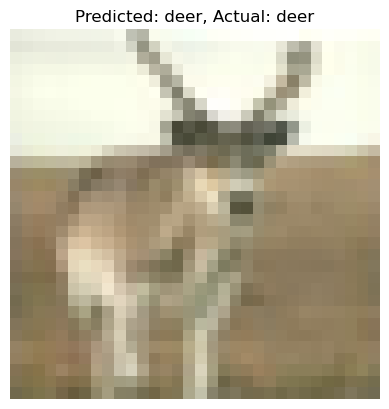

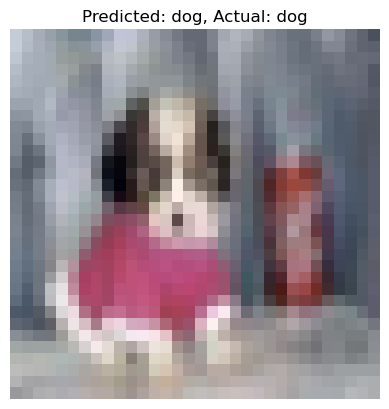

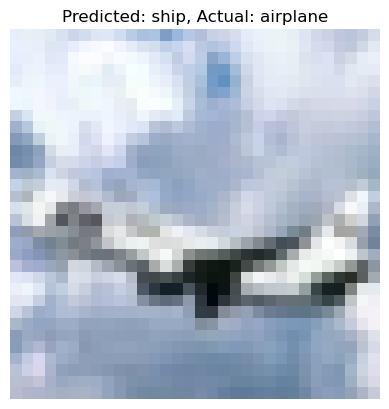

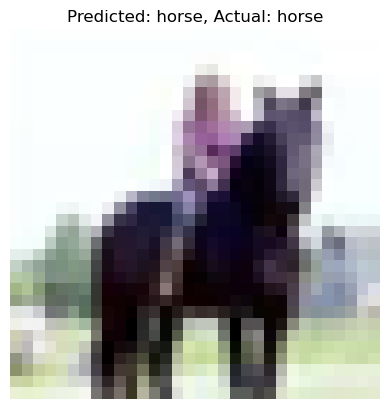

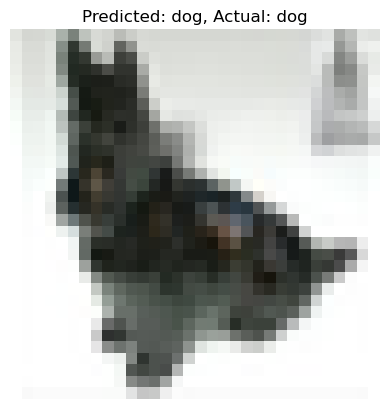

In [163]:
import matplotlib.pyplot as plt

for i in range(5):
    index = np.random.randint(0, X_test.shape[0])  # pick a random image

    # Get flattened image and reshape to column
    x = X_test_flatten[:, index].reshape(-1, 1)

    # Predict
    pred = make_predictions(x, W1, b1, W2, b2)[0]

    # Get actual label
    actual = Y_test[index]

    # Plot image
    plt.imshow(X_test[index])
    plt.title(f"Predicted: {cifar10_labels[pred]}, Actual: {cifar10_labels[actual]}")
    plt.axis('off')
    plt.show()

# Using Flip and Rotation for Generalization (Augmentation)

In [190]:
X_train_conv = []  
print("Starting convolution...")

for idx, img in enumerate(X_train):
    if np.random.rand() < 0.5:
        img = np.fliplr(img)  # horizontal flip
    if np.random.rand() < 0.5:
        img = np.flipud(img)  # vertical flip

    # Augment with random rotation (0, 90, 180, or 270 degrees)
    k = np.random.choice(4)
    img = np.rot90(img, k)  # rotate 90° * k

    padded_img = add_padding(img, pad=1)
    conv_out = np.maximum(0, conv2d_faster(padded_img, filters, stride=1))
    X_train_conv.append(conv_out)

X_train_conv = np.array(X_train_conv)                

# Max Pooling
X_train_max_pooled = []

for idx, img in enumerate(X_train_conv):
    pooled = max_pooling_faster(img, size=2, stride=2)  # (16, 16, 8)
    X_train_max_pooled.append(pooled)
    
X_train_max_pooled = np.array(X_train_max_pooled)

X_train_flatten = X_train_max_pooled.reshape(X_train_max_pooled.shape[0], -1).T

Starting convolution...
  Processed 0/50000 images
  Processed 5000/50000 images
  Processed 10000/50000 images
  Processed 15000/50000 images
  Processed 20000/50000 images
  Processed 25000/50000 images
  Processed 30000/50000 images
  Processed 35000/50000 images
  Processed 40000/50000 images
  Processed 45000/50000 images
Convolution done. Shape: (50000, 32, 32, 8)
Starting max pooling...
  Pooled 0/50000 images
  Pooled 5000/50000 images
  Pooled 10000/50000 images
  Pooled 15000/50000 images
  Pooled 20000/50000 images
  Pooled 25000/50000 images
  Pooled 30000/50000 images
  Pooled 35000/50000 images
  Pooled 40000/50000 images
  Pooled 45000/50000 images
Max pooling done. Shape after pooling: (50000, 16, 16, 8)
(2048, 50000)


# Training Model Again

In [135]:
W1, b1, W2, b2 = gradient_descent_batchwise(X_train_flatten, Y_train, W1, b1, W2, b2, alpha=0.1, iterations=20)
np.savez("weights_biases.npz", W1=W1, b1=b1, W2=W2, b2=b2)

# Testing Again

In [167]:
predictions = make_predictions(X_test_flatten, W1, b1, W2, b2)
accuracy = get_accuracy(predictions, Y_test)
print(f"Test Accuracy: {accuracy*100:.2f}")

[1 5 1 ... 0 1 6] [1 5 8 ... 8 1 6]
Test Accuracy: 78.90
